# Authentication Service 

## Use this to make connections and challenge them to present specific attributes

## Challenge yourself (mobile) to present the workshop attendance credential

Customise as you like. It should be fairly easy to combine this code with the messaging service if you wish

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
from libs.authentication_service import AuthenticationService
import os
import time
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://demo-participant-agent:3021 and an api key of demo-participantsSecretApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Iniitalise the AuthenticationService


In [4]:
authentication_service = AuthenticationService(agent_controller)

## Define Your Presentation Request Object

The one below is for the Aries ACA ACC Jupyter Playground Demo Participation credential. It also requests a self attested attribute for your nickname

In [19]:
# We add a constraint that the attribute must originate from this schema
schema_id='84j4TQBmap9C1C7qXAs6M5:2:Aries Jupyter Playground Demo Participation:0.0.1'


# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "participant", "restrictions": [{"schema_id": schema_id}]},
#     {"name": "nickname", "restrictions": []}
]

# We could extend this to request the name attribute aswell if we wanted.


playground_proof = {
    "name": "Proof of Playground",
    "version": "1.0",
    "requested_attributes": {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
    "non_revoked":  {"to": int(time.time())}
}

## Create Invitation using AuthenticationService

Note the current arguments specified are in their default configurations. 

In [20]:
response = authentication_service.new_connection_invitation(playground_proof, True)

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  d705e1b5-133d-40aa-ad51-469f3a0d9d29
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Share Invitation Object with Other Notebook

In [ ]:
print(response["invitation"])

## Display Invite as QR Code

This is useful if you wish to establish a connection with a mobile wallet.

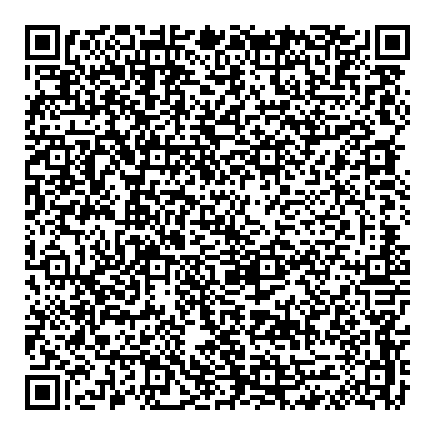

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  d705e1b5-133d-40aa-ad51-469f3a0d9d29
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  d705e1b5-133d-40aa-ad51-469f3a0d9d29
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  d705e1b5-133d-40aa-ad51-469f3a0d9d29
State :  active
Routing State :  none
Their Role :  invitee
----------------------------------------------------------

---------------------------------------------------------------------

Handle present-proof
Connection ID :  d705e1b5-133d-40aa-ad51-469f3a0d9d29
Presentation Exchange ID :  69fba73a-b1e4-46cd-b36e-

In [21]:
import qrcode
# Link for connection invitation
invitation_url = response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Get Connections for Authentication Service



In [29]:
connections = authentication_service.get_connections()
for connection in connections:
    print("Connection ID : ", connection.connection_id)
    print("Is Active : ", connection.is_active.done() and connection.is_active.result() == True)
    print("Is Trusted : ", connection.is_active.done() and connection.is_trusted.done() and connection.is_trusted.result() == True)
    print("Auth Policy Name : " , connection.auth_policy["name"])
    print("Verified Attributes : ", connection.verified_attributes)
    print("Self Attested Attributes : ", connection.self_attested_attributes)

Connection ID :  177b95b8-6121-449c-aa53-d27b7fde9a43
Is Active :  True
Is Trusted :  False
Auth Policy Name :  Proof of Playground Demo Attendance
Verified Attributes :  []
Self Attested Attributes :  []
Connection ID :  47cefe5e-2241-44d3-a0a1-871404f355bc
Is Active :  True
Is Trusted :  False
Auth Policy Name :  Proof of Playground Demo Attendance
Verified Attributes :  []
Self Attested Attributes :  []
Connection ID :  ccd27d8a-2708-4932-91ac-515b8894a17f
Is Active :  True
Is Trusted :  False
Auth Policy Name :  Proof of Playground Demo Attendance
Verified Attributes :  []
Self Attested Attributes :  []
Connection ID :  5e9a8cb2-0cbd-4389-abac-f068f31dbac2
Is Active :  True
Is Trusted :  False
Auth Policy Name :  Proof of Playground Demo Attendance
Verified Attributes :  []
Self Attested Attributes :  []
Connection ID :  c9d88297-aa6a-4484-b98c-2aef68d2453f
Is Active :  True
Is Trusted :  False
Auth Policy Name :  Proof of Playground Demo Attendance
Verified Attributes :  []
Self A

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [22]:
await agent_controller.terminate()